In [1]:
from __future__ import division
import numpy as np
import os
import pylab
import seaborn
import pickle
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Step 1 load data
nb_runs = 3
model_filenames = ['RMB','RMB_arm_only','random']
models_data = {m:[] for m in model_filenames} 
models_bk = {m:[] for m in model_filenames} 

for filename in model_filenames:
    for j in range(nb_runs):
        full_filename = "../logs/"+filename+"_"+str(j)+".pickle"
        if os.path.isfile(full_filename):
            data = pickle.load(open(full_filename,"rb"))
            bk = pickle.load(open("../logs/"+filename+"_"+str(j)+"_book_keeping.pickle","rb"))
            bk['nb_iter'] = len(data['observations'])
            models_data[filename].append(data)
            models_bk[filename].append(bk)
            
nb_iter = bk['nb_iter'] #assumes every model and run has same number of iter 

def process_data(sub_outcomes, data, bk):
    cpt = 0
    zero_like = [-0.87179487, -1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
     -0.87179487, -1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
     -0.87179487, -1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
     -0.87179487 ,-1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
     -0.87179487, -1.     ,     0.73195876, -0.87179487,-1.     ,     0.73195876]
    culb_replaced = []
    zero_like_sum = -11.398361089082734
    for n,d in sub_outcomes.items():
        sub_outcomes[n]['traj'] = []
        sub_outcomes[n]['raw'] = []
        if n == 'culbuto':
            sub_outcomes[n]['arm_it_only'] = []
        for i in range(nb_iter):
            if n == 'culbuto':
                if data['chosen_modules'][i] in diva_modules: # we do not care about objects when vocalizing
                    if not sum(data['observations'][i][d['range']]) == zero_like_sum:
                        culb_replaced.append(i)
                        data['observations'][i][d['range']] = zero_like
                
                if not sum(data['observations'][i][d['range']]) == zero_like_sum:
                    sub_outcomes[n]['arm_it_only'] += np.split(data['observations'][i][d['range']],
                                                                   d['nb_traj_steps']) 
            sub_outcomes[n]['traj'].append(data['observations'][i][d['range']])
            sub_outcomes[n]['raw'] += np.split(data['observations'][i][d['range']], d['nb_traj_steps'])
        sub_outcomes[n]['raw'] = np.array(sub_outcomes[n]['raw'])
        if n == 'culbuto':
            sub_outcomes[n]['arm_it_only'] = np.array(sub_outcomes[n]['arm_it_only'])
    print len(sub_outcomes['hand']['traj'])
    return culb_replaced
    

# Define motor and sensory spaces:
s_hand = range(3, 33)
s_culbuto_1 = range(33, 63)
s_self_sound = range(63, 73)
s_caregiver_sound = range(73, 83)

arm_modules = [1,3,6]
diva_modules = [12,14]

# Extract relevant observation sub parts
models_sub_outcomes = {}
for m in model_filenames:
    models_sub_outcomes[m] = []
    for i in range(nb_runs):
        sub_outcomes = {'hand':{'range': s_hand, 'nb_traj_steps': 10},
                'culbuto':{'range': s_culbuto_1, 'nb_traj_steps': 10},
                'agent_sound':{'range': s_self_sound, 'nb_traj_steps': 5},
                'caregiver_sound':{'range': s_caregiver_sound, 'nb_traj_steps': 5}}
        culbuto_replaced = process_data(sub_outcomes, models_data[m][i], models_bk[m][i])
        models_sub_outcomes[m].append(sub_outcomes)
        models_data[m][i]['culbuto_replaced'] = culbuto_replaced
    

20000
20000
20000
20000
20000
20000
20000
20000
20000


In [3]:
for m in model_filenames:
    for i in range(nb_runs):
        print m+" run "+str(i)
        print "{} iterations loaded: {} arm, {} sound".format(models_bk[m][i]['nb_iter'],
                                                      models_bk[m][i]['nb_motor_it'],
                                                      models_bk[m][i]['nb_sound_it'])

RMB run 0
20000 iterations loaded: 1995 arm, 18005 sound
RMB run 1
20000 iterations loaded: 2043 arm, 17957 sound
RMB run 2
20000 iterations loaded: 1997 arm, 18003 sound
RMB_arm_only run 0
20000 iterations loaded: 2052 arm, 17948 sound
RMB_arm_only run 1
20000 iterations loaded: 2147 arm, 17853 sound
RMB_arm_only run 2
20000 iterations loaded: 1994 arm, 18006 sound
random run 0
20000 iterations loaded: 2044 arm, 17956 sound
random run 1
20000 iterations loaded: 2007 arm, 17993 sound
random run 2
20000 iterations loaded: 2038 arm, 17962 sound


In [4]:
import pickle
from rospkg.rospack import RosPack
import rospy
from os.path import join

# Sound config
def compress_sound_traj(sound):
    assert(len(sound) == 100)
    f1s = sound[:50]
    f3s = sound[50:]
    return np.append(f1s[np.array([0, 12, 24, 37, 49])],f3s[np.array([0, 12, 24, 37, 49])])

v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))

# Retrieve caregiver sounds and trajectories from json
rospack = RosPack()
with open(join(rospack.get_path('pobax_playground'), 'config', 'human_sounds.pickle')) as f:
    full_human_motor_traj, full_human_sounds_traj  = pickle.load(f)
human_sounds = full_human_sounds_traj.keys()
rospy.loginfo('Voice node using the word %s for culbuto name' % human_sounds[0])

vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)

human_sounds = ['eyu', 'oey', 'eou', 'oyi']
print "human sounds", human_sounds

human_sounds_traj = dict()
human_sounds_traj_std = dict()
best_vocal_errors = {}
best_vocal_errors_evolution = []
for hs in human_sounds:
    best_vocal_errors[hs] = 10.
    human_sounds_traj[hs] = compress_sound_traj(full_human_sounds_traj[hs])
    human_sounds_traj_std[hs] = [d - 8.5 for d in human_sounds_traj[hs][:5]] + [d - 10.25 for d in human_sounds_traj[hs][5:]]    
        
sound_tol = 0.4

human sounds ['eyu', 'oey', 'eou', 'oyi']


In [5]:
#print len(models_sub_outcomes['test_res100_rmb'][0]['culbuto']['traj'])

RMB 0


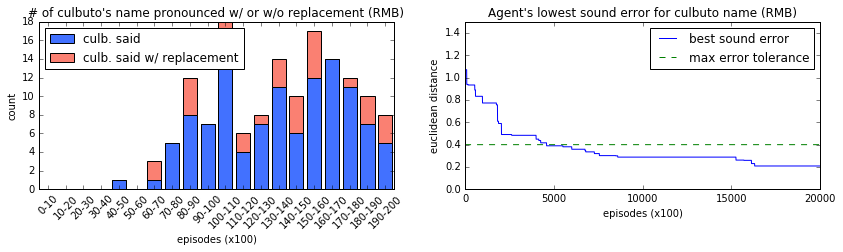

RMB 1


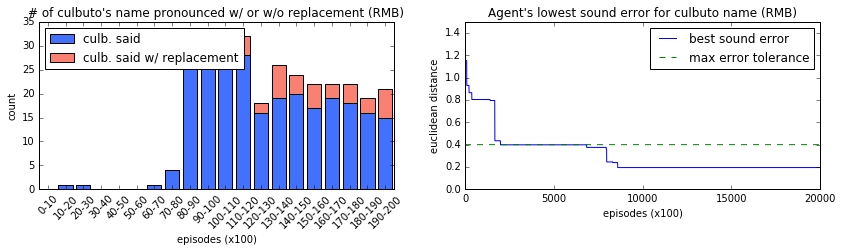

RMB 2


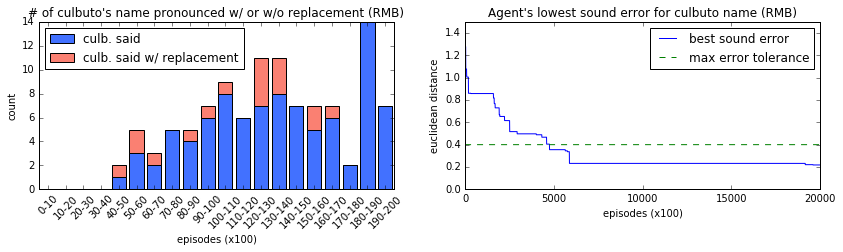

RMB_arm_only 0


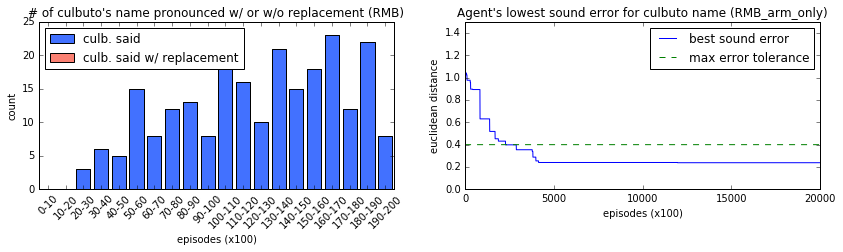

RMB_arm_only 1


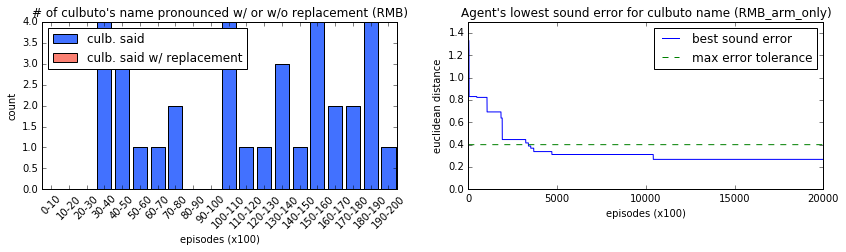

RMB_arm_only 2


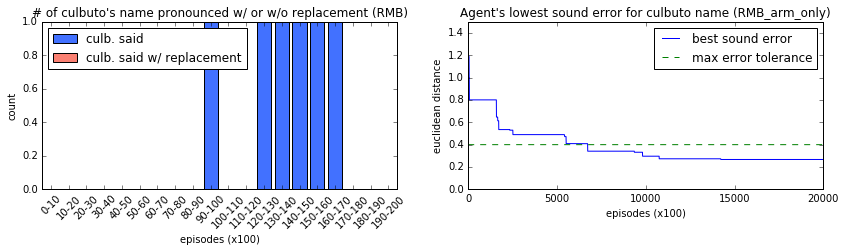

random 0


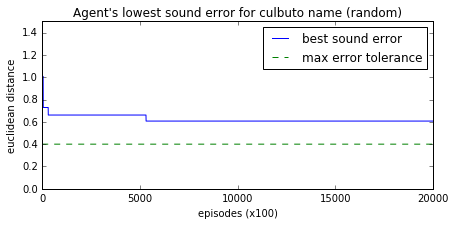

random 1


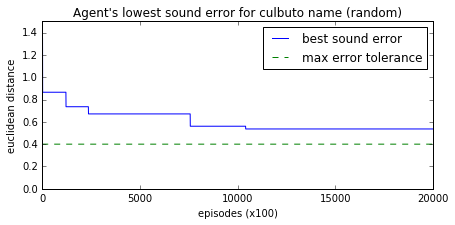

random 2


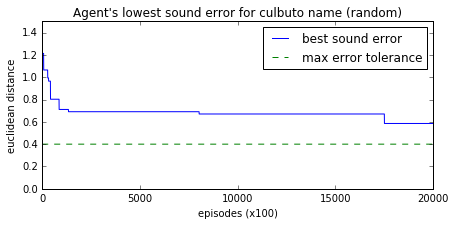

In [6]:
# Plot culbuto name frequency
def analysis_sound(sound, best_vocal_error):
        #return human_sounds[2]
        #print human_sounds_traj
        for hs in human_sounds:
            #sound = np.array([f[0] for f in diva_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in diva_traj[[0, 12, 24, 37, 49]]])
            error = np.linalg.norm(np.array(human_sounds_traj[hs]) - sound)
            if error < best_vocal_error:
                best_vocal_error = error
            if error < sound_tol:
                #print "***********Agent says", hs
                return hs, best_vocal_error
        return None, best_vocal_error

plt.rcParams.update({'font.size': 10})
for m in model_filenames:
    for r in range(nb_runs):
        print m + ' ' + str(r)
        sub_outcomes = models_sub_outcomes[m][r]
        vocal_errors = []
        culb_name_said = []
        best_vocal_error = 10.
        for i,s in enumerate(sub_outcomes['agent_sound']['traj']):
            #denormalize s
            original_s = [d + 8.5 for d in s[:5]] + [d + 10.25 for d in s[5:]]    
            res, best_vocal_error = analysis_sound(original_s, best_vocal_error)
            vocal_errors.append(best_vocal_error)
            if res == 'eyu':
                culb_name_said.append(i)

        # Plot sound error evolution
        if m == 'random':
            f, (ax1) = plt.subplots(1,1,figsize=(7,3))
        else:
            f, (ax2, ax1) = plt.subplots(1,2,figsize=(14,3))
        ax1.plot(vocal_errors,color='blue',label='best sound error')
        ax1.plot([sound_tol]*len(vocal_errors),ls='--',
                 color='green', 
                 label='max error tolerance')
        ax1.set_title("Agent's lowest sound error for culbuto name ("+m+")")
        ax1.set_ylabel('euclidean distance')
        ax1.set_xlabel('episodes (x100)')
        ax1.set_xlim(0,len(vocal_errors))
        ax1.set_ylim(0,1.5)
        ax1.legend()

        # Barplot plot
        if len(culb_name_said) > 0:
            culb_said_not_replaced = []
            culb_said_replaced = []
            for episode in culb_name_said:
                if episode in models_data[m][r]['culbuto_replaced']:
                    culb_said_replaced.append(episode)
                else:
                    culb_said_not_replaced.append(episode)
            barplot_step = 1000
            barplot_steps = np.arange(0,((nb_iter // barplot_step)+1)*barplot_step,barplot_step)
            count_culb_not_replaced = stats.binned_statistic(culb_said_not_replaced,
                                         np.arange(len(culb_said_not_replaced)),
                                         statistic='count',
                                         bins=barplot_steps).statistic
            
            if culb_said_replaced != []:
                count_culb_replaced = stats.binned_statistic(culb_said_replaced,
                                             np.arange(len(culb_said_replaced)),
                                             statistic='count',
                                             bins=barplot_steps).statistic
            else:
                count_culb_replaced = [0.]*len(count_culb_not_replaced)

            width = 0.8      # the width of the bars: can also be len(x) sequence
            ind = np.arange(len(count_culb_replaced))    # the x locations for the groups
            p1 = ax2.bar(ind, count_culb_not_replaced, color=(0.2588,0.4433,1.0),align='center', width=width)
            p2 = ax2.bar(ind, count_culb_replaced, color='salmon', bottom=count_culb_not_replaced,align='center', width=width)

            
            x_labels= []
            for i,val in enumerate(barplot_steps):
                if i < len(barplot_steps)-1:
                    x_labels.append(str(val//100)+'-'+str(barplot_steps[i+1]//100))

            #print x_labels[0::2]
            ax2.set_xticks(ind)
            ax2.set_xticklabels(x_labels,rotation = 45)
            #print ind
            ax2.set_xlim(min(ind)-0.5,max(ind)+0.5)
            
            ax2.set_ylabel('count')
            ax2.set_xlabel('episodes (x100)')
            ax2.set_title("# of culbuto's name pronounced w/ or w/o replacement (RMB)")
            ax2.legend((p1[0],p2[0]),('culb. said','culb. said w/ replacement'), loc=2)
            
            #store data for grid cell plots
            if culb_said_replaced != []:
                models_sub_outcomes[m][r]['first_culb_said_replaced'] = culb_said_replaced[0]
            else:
                models_sub_outcomes[m][r]['first_culb_said_replaced'] = None
                
        #plt.savefig(m+"culbuto_name_pronounced.pdf", bbox_inches='tight')
        #plt.savefig(m+"culbuto_name_pronounced.png", bbox_inches='tight')
        plt.show()
        

In [58]:
# Grid cell exploration curves
metric = ['hand','culbuto','agent_sound']
bins = [10,20,100]

nb_metrics = len(metric)
plot_every = 100
plot_steps = np.arange(plot_every,((nb_iter // plot_every)+1)*plot_every,plot_every)
print plot_steps
models_mean_explo = []
models_std_explo = []
all_explo = []
nb_runs = 3
for model in model_filenames:
    print model
    explo = np.zeros((nb_metrics,nb_runs,len(plot_steps)))
    for r in range(nb_runs):
        print r
        for i, plot_idx in enumerate(plot_steps):
            for m_idx, m in enumerate(metric):
                    nb_dims = models_sub_outcomes[model][r][m]['raw'].shape[1]
                    #print models_sub_outcomes[model][r][m]['raw'].shape
                    samples = models_sub_outcomes[model][r][m]['raw'][:plot_idx*10,:]
                    nb_explored_cells = len(np.unique(stats.binned_statistic_dd(samples,
                                                                                np.arange(len(samples)),
                                                                                bins = bins[m_idx],
                                                                                range=[[-1,1]]*nb_dims).binnumber))
                    nb_cells = bins[m_idx]**nb_dims
                    explo[m_idx,r,i] = (nb_explored_cells / nb_cells)*100
        
        print explo[1,r,i]
    
    all_explo.append(explo)
    mean_explo = np.mean(explo,axis=1)
    std_explo = np.std(explo,axis=1)
    
    models_mean_explo.append(mean_explo)
    models_std_explo.append(std_explo)

[  100   200   300   400   500   600   700   800   900  1000  1100  1200
  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400
  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600
  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800
  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000
  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200
  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400
  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600
  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700 10800
 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000
 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200
 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400
 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600
 15700 15800 15900 16000 16100 16200 16300 16400 16

In [26]:
#print np.unique(models_data['test_res100_random'][0]['chosen_modules'])
range(1,2)

[1]

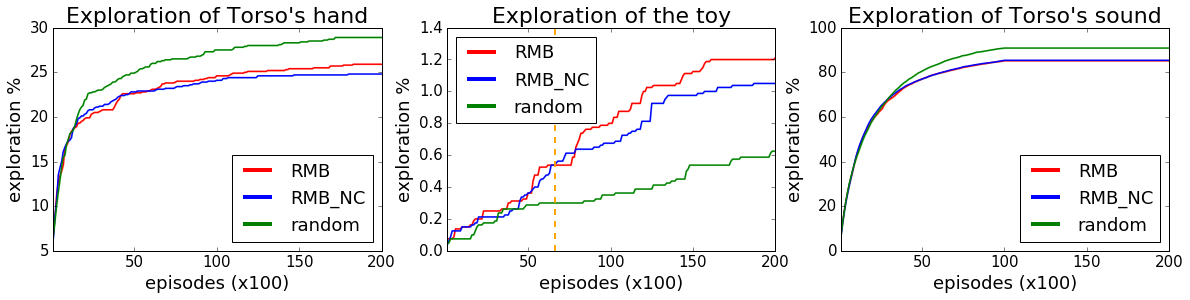

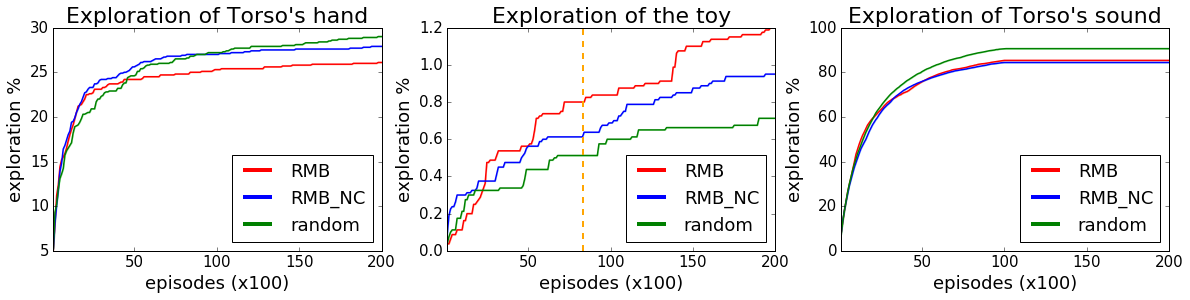

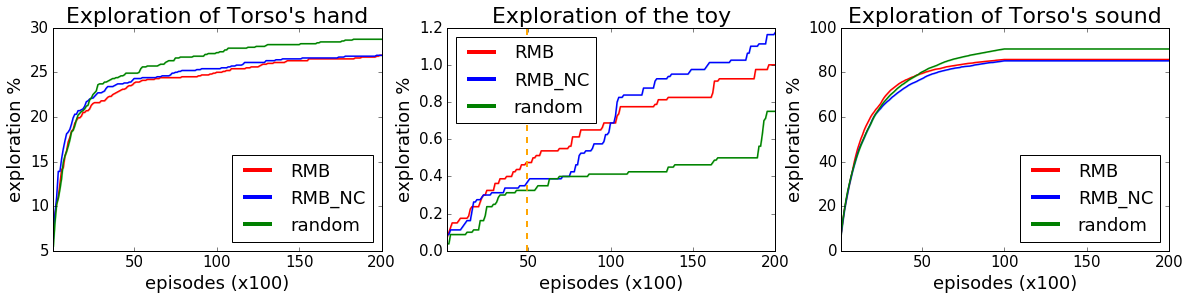

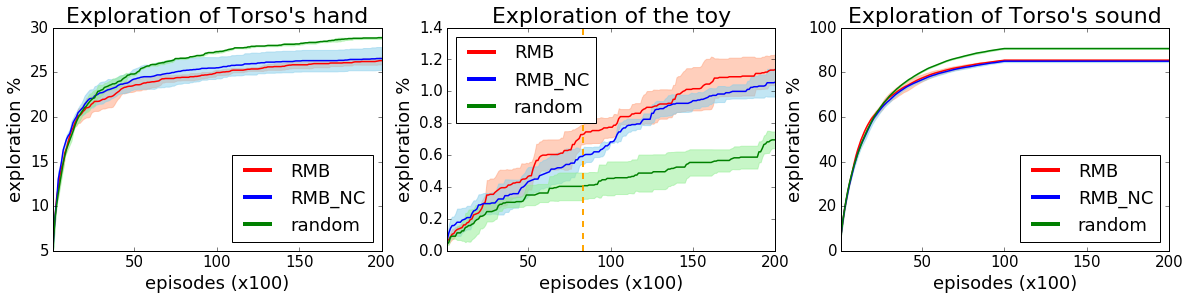

In [59]:
def plot_with_std(ax,x,y,err,color,shade_color,label,y_min=None,y_max=None, legend=False, title=None):
    plt.rcParams.update({'font.size': 15})
    ax.plot(x,y, color=color, label=label,linewidth=1.5)
    ax.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    if legend:
        leg = ax.legend(loc='bottom right')
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
    ax.set_xlabel('episodes (x100)', fontsize=18)
    ax.set_ylabel('exploration %', fontsize=18)
    ax.set_xlim(xmin=min(x),xmax=max(x))
    if y_min is not None:
        ax.ylim(ymin=y_min,ymax=y_max)
    if title:
        ax.set_title(title, fontsize=22)

colors = ['red','blue','green','magenta','black','cyan','orange']
shades_colors = ['lightsalmon','skyblue','lightgreen','violet']
title_info = ["Torso's hand", "the toy", "Torso's sound"]
model_names = ['RMB','RMB_NC','random']
plotpos=[131,132,133]

# Per-run plots
for r in range(nb_runs):
    f, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(20,4))
    ax = (ax0, ax1, ax2)
    for j, explo in enumerate(all_explo):
        for i,m in enumerate(metric):
            y = explo[i,r,:]
            err = np.zeros(len(explo[i,r,:]))
            title = 'Exploration of '
            plot_with_std(ax[i], plot_steps//100,y,err,colors[j],shades_colors[j],model_names[j],
                          title=title+title_info[i], legend=True)
            if m == 'culbuto':
                ax1.axvline(x=models_sub_outcomes['RMB'][r]['first_culb_said_replaced']/100,color='orange',linewidth=1.5, linestyle='--')
                #ax1.axvline(x=94.12,color='green',linewidth=1.5, linestyle='--', label='1st /eyu/ ')
    #plt.savefig("grid_cell_exploration.pdf", bbox_inches='tight')
    #plt.savefig("grid_cell_exploration.png", bbox_inches='tight')
    plt.show()

# Averaged plots
f, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(20,4))
ax = (ax0, ax1, ax2)
for j, (mean_explo, std_explo) in enumerate(zip(models_mean_explo, models_std_explo)):
    for i,m in enumerate(metric):
        y = mean_explo[i,:]
        err = std_explo[i,:]
        title = 'Exploration of '
        plot_with_std(ax[i], plot_steps//100,y,err,colors[j],shades_colors[j],model_names[j],
                      title=title+title_info[i], legend=True)
        if m == 'culbuto':
            pass
#plt.savefig("grid_cell_exploration.pdf", bbox_inches='tight')
#plt.savefig("grid_cell_exploration.png", bbox_inches='tight')
plt.show()


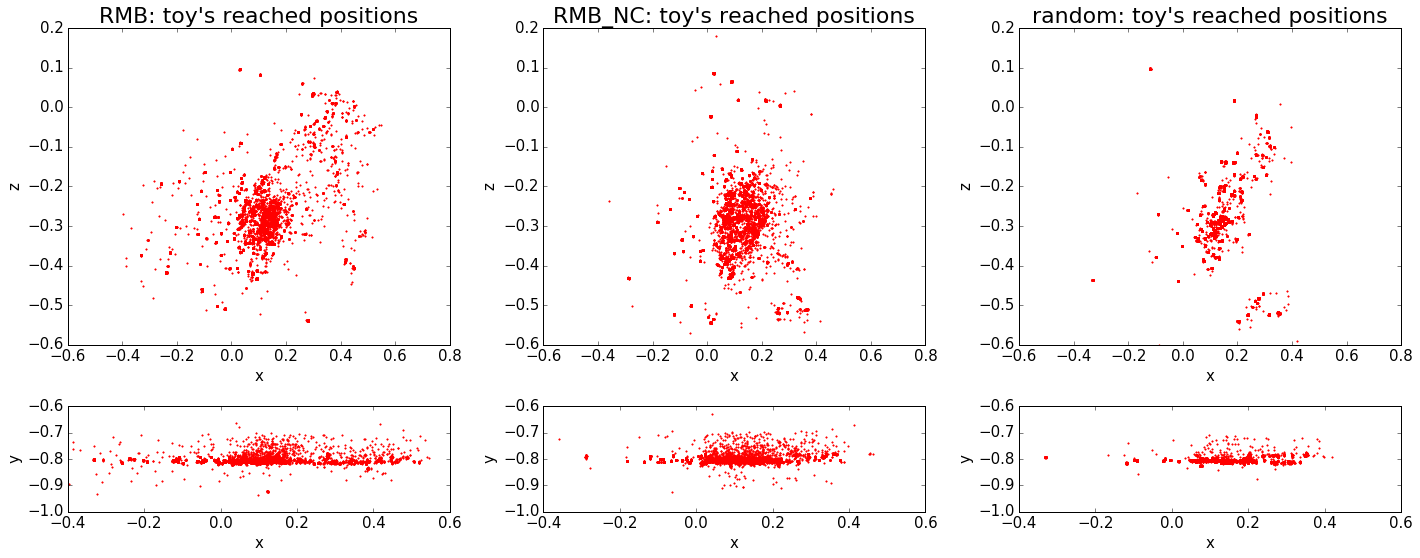

In [94]:
from matplotlib import gridspec
#Quantitative view of culbuto's reached positions
model_names = ['RMB','RMB_NC','random']
fig = plt.figure(figsize=(20, 8)) 
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1]) 
for i,m_name in enumerate(model_filenames):
    for r in range(0,1):
        #print m_name
        sub_outcomes = models_sub_outcomes[m_name][r]
        #f,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
        
        
        ax1 = plt.subplot(gs[0+i])
        ax2 = plt.subplot(gs[3+i])
        a = np.array(sub_outcomes['culbuto']['arm_it_only'])
        #print a.shape
        ax1.plot(a[:,0],a[:,2],'r.',markersize=3)
        ax1.set_xlim(-0.6,0.8)
        ax1.set_ylim(-0.6,0.2)
        ax1.set_xlabel('x')
        ax1.set_ylabel('z')
        ax1.set_title(model_names[i]+": toy's reached positions",fontsize=22)

        ax2.plot(a[:,0],a[:,1],'r.',markersize=3)
        ax2.set_xlim(-0.4,0.6)
        ax2.set_ylim(-1,-0.6)
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.yaxis.major.locator.set_params(nbins=5) 
        #ax2.set_title("[x,y] view")


plt.tight_layout(h_pad=1.0)
plt.savefig(m_name+"culbuto_exploration.pdf", bbox_inches='tight')
plt.savefig(m_name+"culbuto_exploration.png", bbox_inches='tight')
plt.show()


In [11]:
#m='RMB'
#for it in models_data[m][0]['culbuto_replaced']:
#    print it
#    print models_data[m][0]['chosen_modules'][it]

run 0


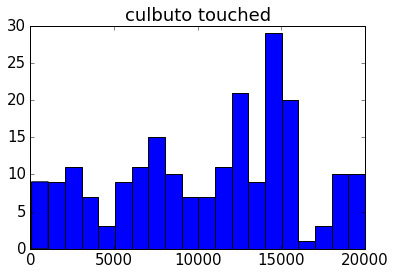

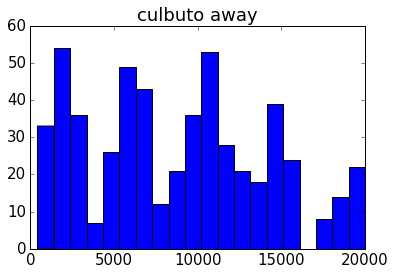

20000
20000
run 1


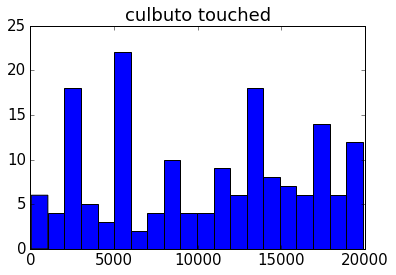

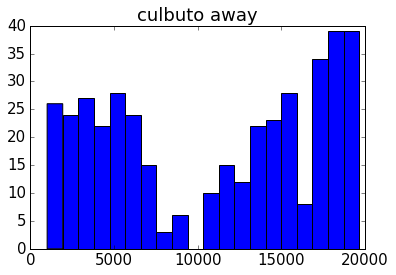

20000
20000
run 2


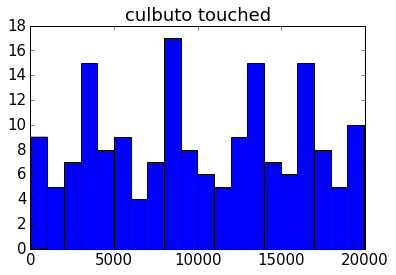

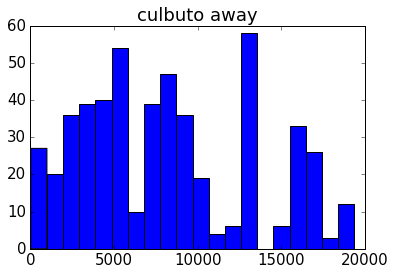

20000
20000


In [99]:
def is_culbuto_touched(culb_traj):
        thr = 9e-06 #variance threshold
        xs = culb_traj[0::3]
        ys = culb_traj[1::3]
        zs = culb_traj[2::3]
        if (np.var(xs) > thr) or (np.var(ys) > thr) or (np.var(zs) > thr):
            return True
        else:
            return False

# Returns True if culbuto is outside torso's armreach, False otw
def is_culbuto_too_far(culb_x, culb_y, culb_z):
    baxter_grasp_bound_x = 0.365
    baxter_grasp_bound_line = [[0.465,0.365],[-0.320,-0.463]]
    if culb_x < baxter_grasp_bound_x:
        return True
    xs,zs = baxter_grasp_bound_line
    a,b = np.polyfit(xs,zs,1) #get line's equation
    if culb_z > (culb_x * a + b):
        return True
    return False

def unscale_vector(scaled_values, bounds):
    mins_maxs_diff =  np.diff(bounds).squeeze()
    mins = bounds[:, 0]
    return (((scaled_values + 1) * mins_maxs_diff) / 2) + mins


culb_bounds = np.array([[-0.05,0.730], [0.03, 0.30],[-0.840,0.130]]*10)
zero_like_sum = -11.398361089082734
plot_every = 100
plot_steps = np.arange(plot_every,((nb_iter // plot_every)+1)*plot_every,plot_every)
# Evolution of succesfull culbuto touching and percentage of culbuto away
m = 'RMB'
#print plot_steps[15:]

for r in range(nb_runs):
    print 'run ' + str(r)
    trying_to_move_culb = []
    moved_culb_while_trying = []
    culbuto_touched = []
    culbuto_away = []
    culb_away = []
    culb_trajs = models_sub_outcomes[m][r]['culbuto']['traj']
    chosen_modules = models_data[m][r]['chosen_modules']

    # extract data
    for i in range(nb_iter):
        is_arm_iter = not(sum(culb_trajs[i]) == zero_like_sum)
        raw_traj = unscale_vector(np.array(culb_trajs[i]), culb_bounds)
        #print 'real: {}'.format(tmp[-3:])
        #print 'norm: {}'.format(culb_trajs[i][-3:])
        if is_culbuto_touched(raw_traj):
            culbuto_touched.append(i)
        
        if chosen_modules[i] == 3: #trying to move culbuto
            trying_to_move_culb.append(1)
            if is_culbuto_touched(raw_traj):
                moved_culb_while_trying.append(1)
            else:
                moved_culb_while_trying.append(-1)
        else:
            trying_to_move_culb.append(0)
            moved_culb_while_trying.append(0)

        last_x = raw_traj[-3]
        last_y = raw_traj[-2]
        last_z = raw_traj[-1] 
        if is_arm_iter:
            #print "last pos: {}".format((last_x,last_y,last_z))
            if is_culbuto_too_far(last_x,last_y,last_z):
                culb_away.append(1)
                culbuto_away.append(i)
            else:
                culb_away.append(-1)
        culb_away.append(0)
    culbuto_accuracies = []
    culb_away_plot = []
    # compute plot values
    for i in plot_steps:
        if trying_to_move_culb[:i].count(1) != 0:
            culb_accuracy = moved_culb_while_trying[:i].count(1) / float(trying_to_move_culb[:i].count(1))
            culbuto_accuracies.append(culb_accuracy)
        else:
            #print 'hehe'
            culbuto_accuracies.append(0)
        culb_away_plot.append(culb_away[:i].count(1) / (culb_away[:i].count(-1) + culb_away[:i].count(1)))
        

#     # actual plotting
#     plt.figure()
#     plt.plot(plot_steps[15:]//100,culbuto_accuracies[15:])
#     plt.xlabel('episodes (x100)')
#     plt.ylabel('culbuto succesfuly touched')
#     plt.title('accuracy of touching culbuto')
#     plt.show()
    
#     # actual plotting
#     plt.figure()
#     plt.plot(plot_steps//100,culb_away_plot)
#     plt.xlabel('episodes (x100)')
#     plt.ylabel('culbuto away %')
#     plt.title('culbuto pushed away evolution')
    
    plt.figure()
    plt.hist(culbuto_touched,bins=20)
    plt.title('culbuto touched')
    
    plt.figure()
    plt.hist(culbuto_away,bins=20)
    plt.title('culbuto away')
    
    plt.show()
        
            
                    
    print len(trying_to_move_culb)
    print len(moved_culb_while_trying)


In [13]:
a = [0,1,0,1,1,1]
b = [0,-1,0,1,1,1]
print a.count(1)
print b.count(1)
print  b.count(1) / a.count(1)


4
3
0.75


In [14]:
plot_steps//100

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [100]:
for m in model_filenames:
    print m
    for r in range(nb_runs):
        print r
        print models_bk[m][r]['nb_culbuto_touched']

RMB
0
212
1
169
2
175
RMB_arm_only
0
254
1
157
2
190
random
0
81
1
78
2
69
